In [10]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta

color_palette = sns.color_palette("Spectral", n_colors=7, desat=0.75)
sns.set_palette(color_palette)
plt.style.use("Solarize_Light2")

eth = yf.Ticker("ETH-USD")

In [11]:
today = datetime.now()
start_date = today - timedelta(days=728)
start_date_2 = start_date - timedelta(days=728)
df = eth.history(start=start_date, end=today, interval="1h")
df.index = pd.to_datetime(df.index).tz_localize(None)
del df["Dividends"]
del df["Stock Splits"]
del df['Volume']
df.columns = [c.lower() for c in df.columns]
df["pct_chg_hour_before"] = df["close"].pct_change(periods=-1)
df["4_hr_future"] = df["close"].shift(-4)
df["target"] = (df["4_hr_future"] > df["close"]).astype(int)
df

,open,high,low,close,pct_chg_hour_before,4_hr_future,target
Datetime,,,,,,,
2022-01-07 00:00:00,3419.213135,3420.461914,3381.788086,3381.788086,-0.003816,3217.915771,0
2022-01-07 01:00:00,3381.305664,3394.742432,3381.113281,3394.742432,0.005426,3233.819824,0
2022-01-07 02:00:00,3394.634766,3394.634766,3376.421875,3376.421875,0.035904,3184.779053,0
2022-01-07 03:00:00,3375.860840,3375.860840,3259.395508,3259.395508,0.012890,3194.934570,0
2022-01-07 04:00:00,3259.211670,3260.087402,3184.239746,3217.915771,-0.004918,3237.155273,1
...,...,...,...,...,...,...,...
2024-01-04 14:00:00,2240.857666,2270.991211,2234.603027,2266.458252,-0.005688,2277.225098,1
2024-01-04 15:00:00,2270.675781,2285.132080,2265.984375,2279.424072,0.003535,NaN,0
2024-01-04 16:00:00,2279.092529,2281.175293,2262.543457,2271.395752,-0.002913,NaN,0


<Axes: xlabel='Datetime'>

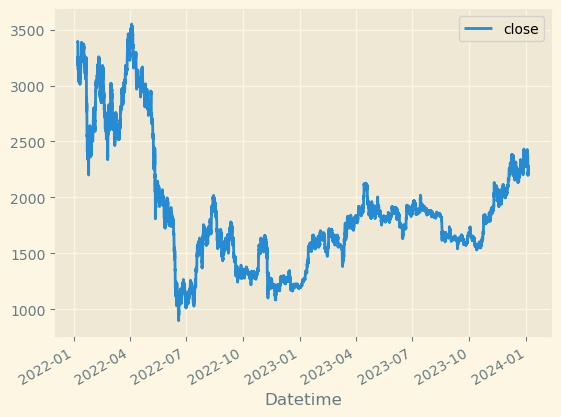

In [12]:
df.plot.line(y="close", use_index=True)

In [13]:
df["target"].value_counts()

target
1    8817
0    8625
Name: count, dtype: int64

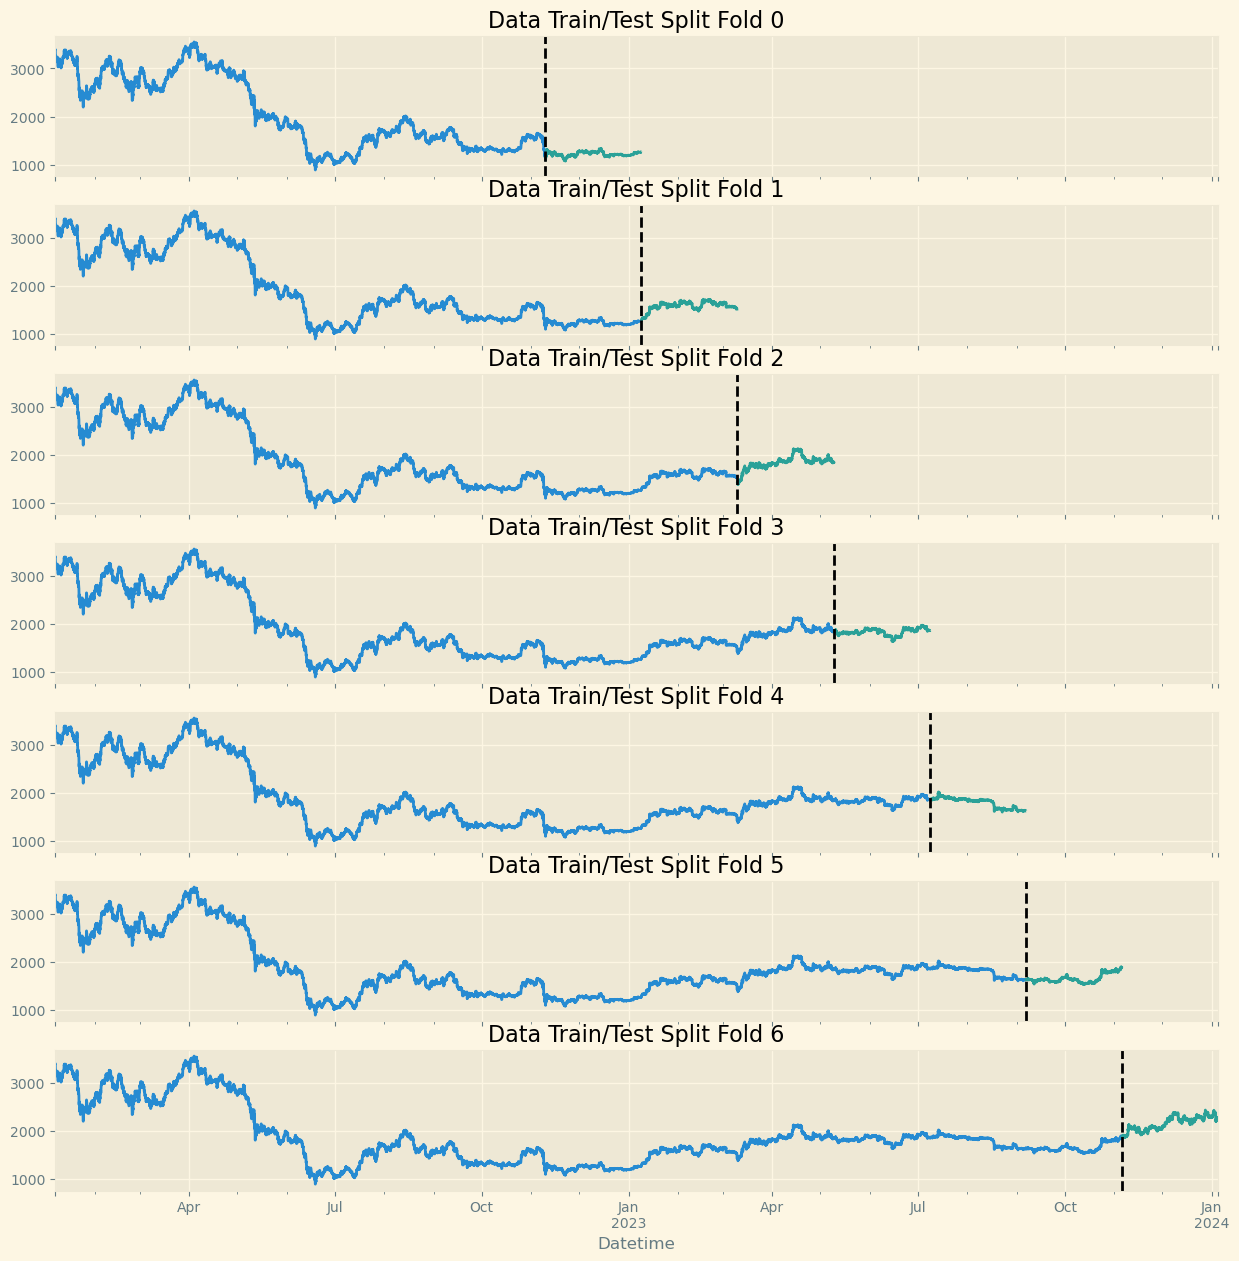

In [14]:
tss = TimeSeriesSplit(n_splits=7, test_size=24 * 60, gap=1)
df = df.sort_index()

fig, axs = plt.subplots(7, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["close"].plot(
        ax=axs[fold], label="Training Set", title=f"Data Train/Test Split Fold {fold}"
    )
    test["close"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1
plt.show()

In [15]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    return df


def add_lags(df):
    target_map = df["close"].to_dict()
    # 364 maps to the same day of the week
    df["lag1"] = (df.index - pd.Timedelta("4 hours")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("12 hours")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("24 hours")).map(target_map)
    df["lag4"] = (df.index - pd.Timedelta("2 days")).map(target_map)
    df["lag5"] = (df.index - pd.Timedelta("5 days")).map(target_map)
    df["lag6"] = (df.index - pd.Timedelta("6 days")).map(target_map)
    return df

df = add_lags(df)
df = create_features(df)

In [18]:
tss = TimeSeriesSplit(n_splits=7, test_size=24 * 60, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = [
        "open",
        "high",
        "low",
        "close",
        "pct_chg_hour_before",
        "lag1",
        "lag2",
        "lag3",
        "lag4",
        "lag5",
        "lag6",
        "hour",
        "dayofweek",
        "quarter",
        "month",
        "year",
        "dayofyear",
        "dayofmonth",
        "weekofyear",
    ]
    TARGET = "target"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    classifier = xgb.XGBClassifier(

    )
    